In [25]:
import numpy as np
#from sympy import Eq, symbols, diff, Derivative as D, Function, sqrt as sqrt_, Abs as abs_, solve
from math import sqrt,log
#from scipy.stats import norm
from matplotlib import pyplot as plt
from ammgammalib import *

# AMMGammaLib Test


## gamma_gain fee_payment  [NOTEST]

In [26]:
square_f = lambda x: 0.5*(x-1)**2
hedged_f = lambda x: 4*((1+x)/2 - sqrt(x))
amm_f = lambda x,f: gamma_gain(1,x,0.75, f)
x_r = np.linspace(0.001,2,1000)
t_r = np.linspace(min(x_r)**2,max(x_r)**2,1000)
t2_r = np.linspace(min(x_r)**2,1**2,100)

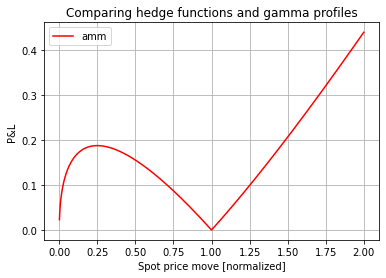

In [27]:
plt.plot(x_r, A(lambda x: amm_f(x,0), x_r), color="red", label="amm")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price move [normalized]")
plt.ylabel("P&L")
plt.grid()

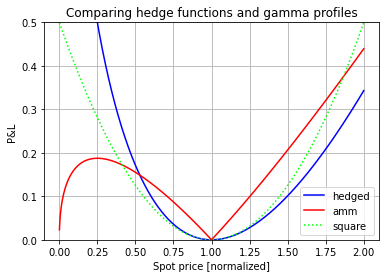

In [28]:
plt.plot(x_r, A(hedged_f, x_r), color="blue", label="hedged")
plt.plot(x_r, A(lambda x: amm_f(x,0), x_r), color="red", label="amm")
plt.plot(x_r, A(square_f, x_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.5)
plt.grid()

In [29]:
feepc = 0.10
square2_f = lambda x: 1*(x-1)**2
tt_r = np.linspace(min(x_r)**2,0.1,1000)

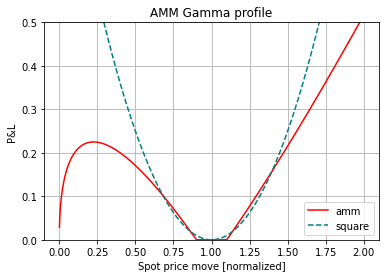

In [30]:
plt.plot(x_r, A(lambda x: amm_f(x,feepc), x_r), color="red", label="amm")
plt.plot(x_r, A(square2_f, x_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"AMM Gamma profile")
plt.xlabel("Spot price move [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.5)
plt.grid()

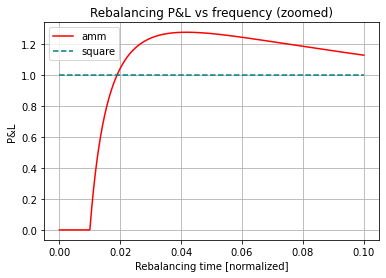

In [31]:
E = lambda f,t: 0.5*(f(1+sqrt(t))+f(1+sqrt(t))) # EV under binary distribution(mean=1, sdev=sqrt(t))
plt.plot(tt_r, A(lambda t: E(lambda x: amm_f(x,feepc),t) / t, tt_r), color="red", label="amm")
plt.plot(tt_r, A(lambda t: E(square2_f,t) / t, tt_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"Rebalancing P&L vs frequency (zoomed)")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.grid()

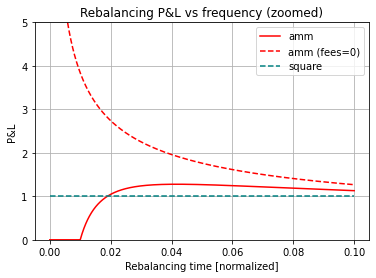

In [32]:
plt.plot(tt_r, A(lambda t: E(lambda x: amm_f(x,feepc),t) / t, tt_r), color="red", label="amm")
plt.plot(tt_r, A(lambda t: E(lambda x: amm_f(x,0),t) / t, tt_r), linestyle="dashed", color="red", label="amm (fees=0)")
plt.plot(tt_r, A(lambda t: E(square2_f,t) / t, tt_r), linestyle="dashed", color="teal", label="square")
plt.legend()
plt.title(f"Rebalancing P&L vs frequency (zoomed)")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,5)
plt.grid()

In [33]:
p0 = 1000     # current price
fee = 0.001   # fee (as fraction; eg 0.001 = 0.10%)
rg = 0.01     # viewport range (as fraction)

p_r = np.linspace((1-rg)*p0,(1+rg)*p0, 200)         # price range [p0*(1+-rg)]
gamma_r = A(lambda x: gamma_gain(p0,x), p_r)        # gamma gain as function of price p in p_r
fee_r = A(lambda x:fee_payment(fee,x), p_r)         # fee as function of price p in p_r

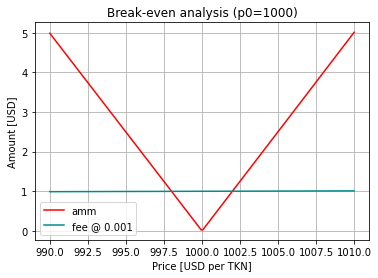

In [34]:
plt.plot(p_r, gamma_r, color="red", label="amm")
plt.plot(p_r, fee_r, color="darkcyan", label=f"fee @ {fee}")
plt.title(f"Break-even analysis (p0={p0})")
plt.xlabel("Price [USD per TKN]")
plt.ylabel("Amount [USD]")
plt.legend()
plt.grid()

## AMMSim [TEST]

In [35]:
Sim = AMMSim(p0=2, tvl0=400)
assert Sim.p_marg==2
assert Sim.x==100
assert Sim.y==200
assert Sim.k==100*200
assert Sim.bleed == 0
assert Sim.fees == 0
assert Sim.ntrades == 0
assert Sim.nreverted == 0

In [36]:
sim = AMMSim(p0=100, feepc=0.10)

t = sim.trade_to(150)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")
assert sim.p_marg == 150
assert round(t.bleed-2.53,1) == 0
assert round(t.fee-1.12,1) == 0
assert t.reverted == False

t = sim.trade_to(130)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")
assert sim.p_marg == 150
assert round(t.bleed-0.29,1) == 0
assert round(t.fee-0.42,1) == 0
assert t.reverted == True

t = sim.trade_to(100)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")
assert sim.p_marg == 100
assert round(t.bleed-2.06,1) == 0
assert round(t.fee-1.12,1) == 0
assert t.reverted == False

p=150.0, bleed=2.53, fee=1.12, reverted=False
p=150.0, bleed=0.29, fee=0.42, reverted=True
p=100.0, bleed=2.06, fee=1.12, reverted=False


## AMMSim Demo [NOTEST]

In [37]:
Sim = AMMSim(p0=2, tvl0=400)

In [38]:
pvals = []
for _ in range(10000):
    p = create_prices(0.1,100)
    pvals += [p[-1]]
logpvals = [log(p) for p in pvals]
var = sum(x**2 for x in logpvals)/len(logpvals)-(sum(logpvals)/len(logpvals))**2
print("average", sum(pvals)/len(pvals))
print ("logvar, logsd", var, sqrt(var))

average 99.97021646885828
logvar, logsd 0.009953195625314493 0.09976570365268063


Below we see a number of example of `create_prices`, creating price paths of differing granularity for covering the same time period. 

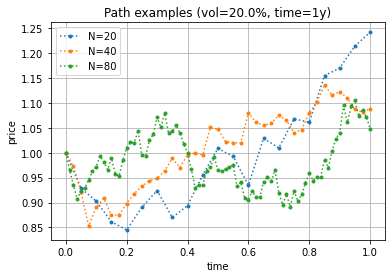

In [39]:
vol=0.2
T=1
for n, in zip([20,40,80]):
    plt.plot(np.linspace(0,1,n+1), create_prices(vol, n, T, add_p0=True), 
             linestyle="dotted", marker=".", label=f"N={n}")
plt.title(f"Path examples (vol={vol*100}%, time={T}y)")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.grid()

In [40]:
sims = []
for _ in range(1000):
    p_r = create_prices(0.2, np.random.randint(10,1000))
    sim = AMMSim(p0=100,feepc=0.01)
    sims += [sim]
    for p in p_r:
        sim.trade_to(p)
    #print(sim.ntrades, sim.feecapture)

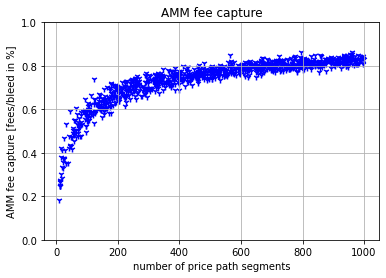

In [41]:
plt.scatter([s.ntrades for s in sims], [s.feecapture for s in sims], marker="1", color="blue")
plt.title("AMM fee capture")
plt.xlabel("number of price path segments")
plt.ylabel("AMM fee capture [fees/bleed in %]")
plt.ylim(0,1)
plt.grid()

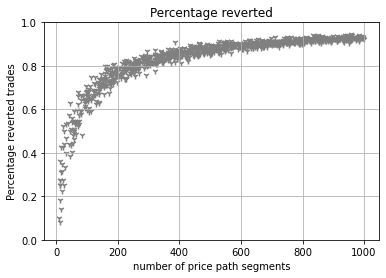

In [42]:
plt.scatter([s.ntrades for s in sims], [s.pcreverted for s in sims], marker="1", color="grey")
plt.title("Percentage reverted")
plt.xlabel("number of price path segments")
plt.ylabel("Percentage reverted trades")
plt.ylim(0,1)
plt.grid()

### Systematic analysis

In [43]:
N_STEPS_MAX = 20
N_r = np.array([10*1.5**n for n in range(N_STEPS_MAX)])
SIGMA = 0.5

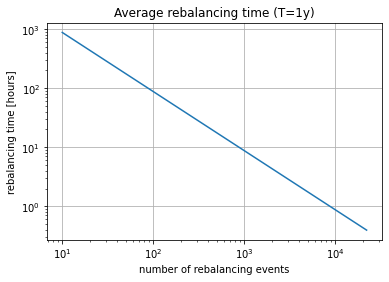

In [44]:
plt.plot(N_r, 24*365/N_r)
plt.title(f"Average rebalancing time (T=1y)")
plt.xlabel("number of rebalancing events")
plt.ylabel("rebalancing time [hours]")
plt.xscale("log")
plt.yscale("log")
plt.grid()

In [45]:
FEEPC = 0.001
feecapture_001_r = []
pcreverted_001_r = []
for n in N_r:
    n = int(n)
    print(f"N={n}")
    sims = []
    NN = int(100000/n)
    if NN < 20: NN = 20
    for _ in range(NN):
        p_r = create_prices(SIGMA, n)
        sim = AMMSim(p0=100,feepc=FEEPC)
        sims += [sim]
        for p in p_r:
            sim.trade_to(p)
    feecapture_001_r += [sum(s.feecapture for s in sims)/NN]
    pcreverted_001_r += [sum(s.pcreverted for s in sims)/NN]
print("DONE")

N=10
N=15
N=22
N=33
N=50
N=75
N=113
N=170
N=256
N=384
N=576
N=864
N=1297
N=1946
N=2919
N=4378
N=6568
N=9852
N=14778
N=22168
DONE


In [46]:
N_r = [10*1.5**n for n in range(N_STEPS_MAX)]
FEEPC = 0.005
feecapture_005_r = []
pcreverted_005_r = []
for n in N_r:
    n = int(n)
    print(f"N={n}")
    sims = []
    NN = int(100000/n)
    if NN < 20: NN = 20
    for _ in range(NN):
        p_r = create_prices(SIGMA, n)
        sim = AMMSim(p0=100,feepc=FEEPC)
        sims += [sim]
        for p in p_r:
            sim.trade_to(p)
    feecapture_005_r += [sum(s.feecapture for s in sims)/NN]
    pcreverted_005_r += [sum(s.pcreverted for s in sims)/NN]
print("DONE")

N=10
N=15
N=22
N=33
N=50
N=75
N=113
N=170
N=256
N=384
N=576
N=864
N=1297
N=1946
N=2919
N=4378
N=6568
N=9852
N=14778
N=22168
DONE


In [47]:
N_r = [10*1.5**n for n in range(N_STEPS_MAX)]
FEEPC = 0.01
feecapture_01_r = []
pcreverted_01_r = []
for n in N_r:
    n = int(n)
    print(f"N={n}")
    sims = []
    NN = int(100000/n)
    if NN < 20: NN = 20
    for _ in range(NN):
        p_r = create_prices(SIGMA, n)
        sim = AMMSim(p0=100,feepc=FEEPC)
        sims += [sim]
        for p in p_r:
            sim.trade_to(p)
    feecapture_01_r += [sum(s.feecapture for s in sims)/NN]
    pcreverted_01_r += [sum(s.pcreverted for s in sims)/NN]
print("DONE")

N=10
N=15
N=22
N=33
N=50
N=75
N=113
N=170
N=256
N=384
N=576
N=864
N=1297
N=1946
N=2919
N=4378
N=6568
N=9852
N=14778
N=22168
DONE


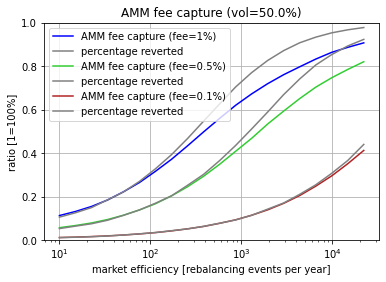

In [48]:
plt.plot(N_r, feecapture_01_r, marker="", color="blue",label="AMM fee capture (fee=1%)")
plt.plot(N_r, pcreverted_01_r, marker="", color="grey",label="percentage reverted")
plt.plot(N_r, feecapture_005_r, marker="", color="limegreen",label="AMM fee capture (fee=0.5%)")
plt.plot(N_r, pcreverted_005_r, marker="", color="grey",label="percentage reverted")
plt.plot(N_r, feecapture_001_r, marker="", color="firebrick",label="AMM fee capture (fee=0.1%)")
plt.plot(N_r, pcreverted_001_r, marker="", color="grey",label="percentage reverted")

plt.title(f"AMM fee capture (vol={SIGMA*100}%)")
plt.xlabel("market efficiency [rebalancing events per year]")
#plt.ylabel("AMM fee capture [fees/bleed in %]")
plt.ylabel("ratio [1=100%]")
plt.xscale("log")
plt.ylim(0,1)
plt.legend()
plt.grid()